#  Решение уравнения пьезопроводности

Уравнение пьезопроводности в радиальной системе координат

$$ \frac{\partial P}{\partial t} = \left( 
    \frac{\partial^2 P}{\partial r^2} + \frac{1}{r} \frac{\partial P}{\partial r}
\right) \varkappa $$

$$ \frac{P_{i}^{n+1} - P_{i}^{n}}{\tau} = \left( 
    \frac{P_{i-1}^{n+1} - 2 P_{i}^{n+1} + P_{i+1}^{n+1}}{h^2} + \frac{1}{r_i} \frac{P_{i+1}^{n+1} - P_{i-1}^{n+1}}{2h}
\right) \varkappa $$

В явном виде:

$$
P_{i}^{n+1} = \frac{\varkappa \tau (2r_i - h)}{2 r_i h^2} P_{i-1}^{n} - \left( \frac{2 \varkappa \tau}{h^2} - 1 \right) P_{i}^{n} + \frac{\varkappa \tau (2r_i + h)}{2r_i h^2} P_{i+1}^{n}
$$

В неявном виде:

$$
\frac{\varkappa \tau (2r_i - h)}{2 r_i h^2} P_{i-1}^{n+1} - \left( \frac{2 \varkappa \tau}{h^2} + 1 \right) P_{i}^{n+1} + \frac{\varkappa \tau (2r_i + h)}{2r_i h^2} P_{i+1}^{n+1} = - P_{i}^{n}
$$

$$
\varkappa \tau \left( 2 r_i - h \right) P_{i-1}^{n+1} - 2 r_i \left( 2 \varkappa \tau + h^2 \right) P_{i}^{n+1} + \varkappa \tau \left( 2 r_i + h \right) P_{i+1}^{n+1} = - 2 h^2 r_i P_{i}^{n}
$$

$$
a_i P_{i-1}^{n+1} - c_i P_{i}^{n+1} + b_i P_{i+1}^{n+1} = - f_i
$$

Число Куранта должно быть меньше 0.5 для явного метода:

$$
C = \frac{\varkappa \tau}{h} ≤ 0.5
$$

## Загрузка библиотек, данные

In [1]:
'''
If you are using Google Colab, uncomment the next line to download `SLAU.py` !!!
'''
# !wget -P /crc/ https://raw.githubusercontent.com/lnrsmglln/1D_filtration/main/SLAU.py

'\nIf you are using Google Colab, uncomment the next line to download `SLAU.py` !!!\n'

In [2]:
%load_ext autoreload
%autoreload 2

import sys
if ".." not in sys.path:
    sys.path.insert(0, "..")
from src import SLAU

import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Физ. данные
T = 100

rc = 0.1
Rk = 50.

Pc = 2 * 10**6
Pk = 1 * 10**6

kappa = 0.8

# Параметры модели
h = 1
tau = 0.5

# Initialization
r = np.arange(rc, Rk + rc, h)
t = np.arange(0, T + tau, tau)
N = r.shape[0]
Nt = t.shape[0]

P = np.zeros([Nt, N])
P[0, :] = Pk    # Нач условие
P[:, 0], P[:, -1] = Pc, Pk      # Граничные условия

Co = kappa * tau / h
print("Courant number =", Co)
if Co >= 0.5:
    print("Внимание! Уменьшите шаг по времени или увеличьте шаг по координате, иначе явный метод покажет некорректный результат")

Courant number = 0.4


## Явный метод

In [4]:
P_explicit = np.ones_like(P, dtype=float) * P
for n in range(1, Nt):
    for i in range(1, N-1):
        P_explicit[n, i] = kappa * tau * (2 * r[i] - h) / (2 * r[i] * h**2) * P_explicit[n-1, i-1] - \
        (2 * kappa * tau / (h**2) - 1) * P_explicit[n-1, i] + \
            kappa * tau * (2 * r[i] + h) / (2 * r[i] * h**2) * P_explicit[n-1, i+1]

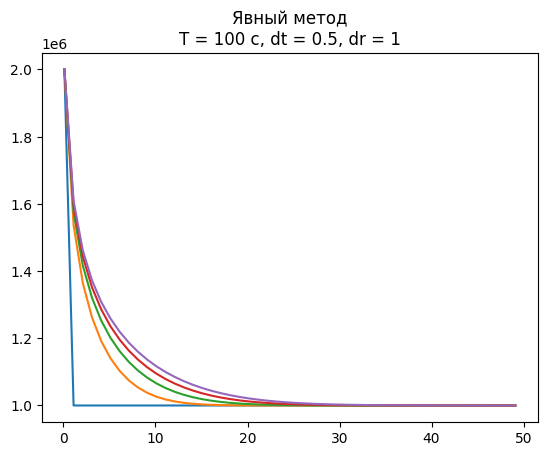

In [5]:
# num_of_curves - кол-во кривых на графике
num_of_curves = 5

j = 0
for i in P_explicit:
    if j % (Nt // (num_of_curves - 1)) == 0:
        plt.plot(r, i)
    j += 1

plt.title(f"Явный метод\nT = {T} c, dt = {round(tau, 3)}, dr = {round(h, 3)}")
plt.show()

## Неявный метод

In [6]:
P_implicit = np.ones_like(P, dtype=float) * P
Nx = N - 2
for n in range(1, Nt):
    a = np.zeros(Nx, dtype=float)
    b = np.zeros(Nx, dtype=float)
    c = np.zeros(Nx, dtype=float)
    f = np.zeros(Nx, dtype=float)
    j = 0
    for i in range(1, N - 1):
        a[j] = kappa * tau * (2 * r[i] - h)
        c[j] = 2 * r[i] * (2 * kappa * tau + h * h)
        b[j] = kappa * tau * (2 * r[i] + h)
        f[j] = 2 * P_implicit[n-1, i] * h * h * r[i]
        j += 1
    P_implicit[n, 1:N-1] = SLAU.tridiagonal_1D_solver(a, b, c, f, P_implicit[n, 0], P_implicit[n, -1])

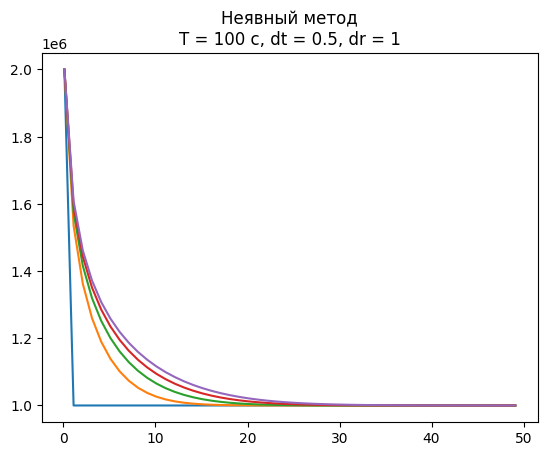

In [7]:
j = 0
for i in P_implicit:
    if j % (Nt // (num_of_curves - 1)) == 0:
        plt.plot(r, i)
    j += 1

plt.title(f"Неявный метод\nT = {T} c, dt = {round(tau, 3)}, dr = {round(h, 3)}")
plt.show()

## Сравнение методов

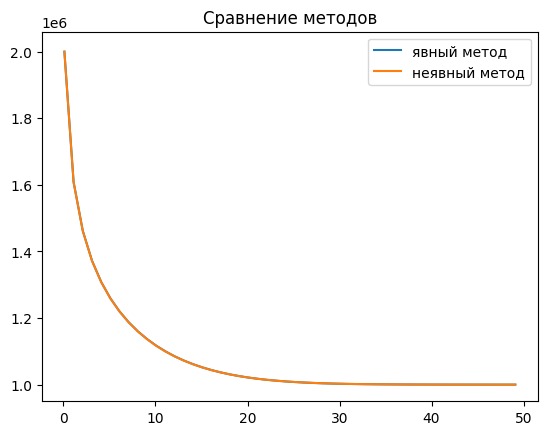

In [8]:
plt.plot(r, P_explicit[-1])
plt.plot(r, P_implicit[-1])
plt.legend(["явный метод","неявный метод"])
plt.title("Сравнение методов")

if Pc > Pk:
    plt.ylim([Pk*0.95, Pc*1.03])
else:
    plt.ylim([Pc*0.95, Pk*1.03])

plt.show()